## policy optimization and evalution on synthetic data

In [1]:
suppressWarnings(suppressMessages(library(tidyverse)))
suppressWarnings(suppressMessages(library(caret)))
suppressWarnings(suppressMessages(library(mlr)))
suppressWarnings(suppressMessages(library(boot)))

In [2]:
sessionInfo()

R version 4.2.1 (2022-06-23)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Red Hat Enterprise Linux

Matrix products: default
BLAS/LAPACK: /usr/local/app/rcs_bin/grid3/envs/rcs_2022.11/lib/libopenblasp-r0.3.21.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] boot_1.3-28         mlr_2.19.1          ParamHelpers_1.14.1
 [4] caret_6.0-93        lattice_0.20-45     forcats_0.5.2      
 [7] stringr_1.4.1       dplyr_1.0.10        purrr_0.3.5        
[10] readr_2.1.3         tidyr_1.2.1         tibble_3.1.8       
[13] ggplot2_3.3.6       tid

In [3]:
setwd('/export/home/faculty/jeryang/Code/log/github')

In [4]:
df1_syn = read.csv('synthetic.csv')

In [5]:
head(df1_syn)

,rev_1,rev_2,rev_3,rev_4,rev_5,rev_6,y0_6,y0_5,y0_4,y0_3,⋯,spotlight_last_6month,page_not_found_last_6month,nation_last_6month,north_last_6month,magazine_last_6month,circulars_last_6month,politics_last_6month,treated,p_treated,subscriber_id
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<int>
1,148.5777,149.6544,150.3133,154.5885,153.9781,154.9029,151.8344,151.6583,151.1057,149.7935,⋯,0,0,0,0,6,0,0,0,0.014109823,1
2,135.2423,136.4555,139.7464,143.6007,145.4772,148.4449,132.6310,133.7848,134.0365,131.1771,⋯,0,0,0,0,0,0,0,0,0.008768083,2
3,149.8397,150.4988,152.1911,153.5927,153.5014,156.1054,147.1067,145.8603,145.7567,146.0290,⋯,1,0,0,0,13,0,0,0,0.007760824,3
4,150.0076,152.6565,153.1486,153.2695,153.3386,154.0745,153.0060,151.9102,151.8562,151.5619,⋯,0,0,0,0,40,0,0,0,0.007268439,4
5,142.2679,145.8702,147.1414,148.4967,150.0394,149.6568,144.4684,144.0554,141.9023,142.3383,⋯,0,0,1,0,1,0,0,0,0.008042505,5
6,145.3205,147.8246,149.6663,151.7460,152.7276,153.7142,148.4780,148.4432,147.7158,146.3450,⋯,0,0,0,0,8,0,0,0,0.008009808,6


### optimize policy on synthetic data

In [6]:
# convert covariates into model matrix for prediction
df_X = select(df1_syn, -subscriber_id, -treated, -p_treated, -contains('y0'), -contains('y1'), -contains('rev'))
df_X = model.matrix(~.-1, df_X) %>% as.data.frame
colnames(df_X) = paste0('col',seq(1,ncol(df_X)))

In [7]:
# split training and test data, test data will be used in policy evaluation
set.seed(101)
train_id = sort(sample(nrow(df_X), nrow(df_X)*0.8))

In [8]:
# policy optimization
optimize_binary_policy <- function(
                            mu, # load data with pre-treatment covariates, surrogates, predicted outcomes and imputed outcomes
                            id, # id to match the data with
                            outcome, # specify which outcome to use to optimize the policy 
                            train_id){ # vector of row numbers used in training 
                                   
mu = arrange(mu, id)    
mu = rename(mu,rev = all_of(outcome))

# construct doubly robust scores
mu$y0_dr = ifelse(mu$treated == 1, mu$y0, mu$y0 + (mu$rev - mu$y0)/(1-mu$p_treated))
mu$y1_dr = ifelse(mu$treated == 0, mu$y1, mu$y1 + (mu$rev - mu$y1)/(mu$p_treated))
mu$tau_dr = mu$y1_dr - mu$y0_dr
    
# construct misclassification cost
cost = data.frame(control = rep(0,nrow(mu)), treat = rep(0,nrow(mu)))
cost$control = ifelse(mu$tau_dr < 0,0,abs(mu$tau_dr))
cost$treat = ifelse(mu$tau_dr > 0,0,abs(mu$tau_dr))

# convert covariates into model matrix
df_X = select(mu, -subscriber_id, -treated, -p_treated, -contains('y0'), -contains('y1'), -contains('rev'), -contains('dr'))
df_X = model.matrix(~.-1, df_X) %>% as.data.frame
colnames(df_X) = paste0('col',seq(1,ncol(df_X)))

# specify cost-sensitive classifier
obp = makeCostSensTask(id = "binary-action policy learning", 
                       data = df_X[train_id,], 
                       cost = cost[train_id,])

# specify learner with pre-tuned hyperparameters 
learner = makeLearner("classif.xgboost",
                      predict.type = "prob",
                      eval_metric = 'logloss',
                      eta = 0.3,
                      max_depth = 6,
                      gamma = 0,
                      colsample_bytree = 0.6,
                      min_child_weight = 1,
                      subsample = 1,
                      nrounds = 150)
learner = makeCostSensWeightedPairsWrapper(learner)

# train the classifier
obp = mlr::train(learner, obp)

return(obp)

}

In [9]:
df_6 = rename(df1_syn, y0 = y0_6, y1 = y1_6)
obp_6 = optimize_binary_policy(df_6, 'subscriber_id', 'rev_6', train_id) # optimize policy with 18-month surrogate index constructed with surrogates in the first 6 months

df_5 = rename(df1_syn, y0 = y0_5, y1 = y1_5)
obp_5 = optimize_binary_policy(df_5, 'subscriber_id', 'rev_5', train_id) # optimize policy with 18-month surrogate index constructed with surrogates in the first 5 months

df_4 = rename(df1_syn, y0 = y0_4, y1 = y1_4)
obp_4 = optimize_binary_policy(df_4, 'subscriber_id', 'rev_4', train_id) # optimize policy with 18-month surrogate index constructed with surrogates in the first 4 months

df_3 = rename(df1_syn, y0 = y0_3, y1 = y1_3)
obp_3 = optimize_binary_policy(df_3, 'subscriber_id', 'rev_6', train_id) # optimize policy with 18-month surrogate index constructed with surrogates in the first 3 months

df_2 = rename(df1_syn, y0 = y0_2, y1 = y1_2)
obp_2 = optimize_binary_policy(df_2, 'subscriber_id', 'rev_2', train_id) # optimize policy with 18-month surrogate index constructed with surrogates in the first 6 months

df_1 = rename(df1_syn, y0 = y0_1, y1 = y1_1)
obp_1 = optimize_binary_policy(df_1, 'subscriber_id', 'rev_1', train_id) # optimize policy with 18-month surrogate index constructed with surrogates in the first 1 month

### evaluate policy on synthetic data

In [10]:
# compare a policy with a benchmark policy that treats no one
policy_eval_benchmark <- function(test,indices) {
  
  test_b = test[indices,]

  test_b$p_no_one = ifelse(test_b$treated==1, 0, 1)
  test_b$p_design = ifelse(test_b$treated==1, test_b$p_treated, 1-test_b$p_treated)
    
  test_b$p_dr = ifelse(test_b$response == 'treat',test_b$treated,1-test_b$treated) 
  test_b$p_dr_treat <- ifelse(test_b$response == 'treat',1,0)
    
  rev_no_one = with(test_b, mean(y0 + 
                             p_no_one/p_design*(rev - (y1*treated + y0*(1-treated)))))   

  rev_dr = with(test_b, mean(y1*p_dr_treat + y0*(1-p_dr_treat) + 
                             p_dr/p_design*(rev - (y1*treated + y0*(1-treated)))))
  
  return(c(rev_dr - rev_no_one))
    
}

In [11]:
df_X = select(df1_syn, -subscriber_id, -treated, -p_treated, -contains('y0'), -contains('y1'), -contains('rev'))
df_X = model.matrix(~.-1, df_X) %>% as.data.frame
colnames(df_X) = paste0('col',seq(1,ncol(df_X)))

test_X = df_X[-train_id,]
test = cbind(test_X, df1_syn[-train_id,] %>%
            select(subscriber_id, treated, p_treated, contains('y0'), contains('y1'), contains('rev')))

In [12]:
test_6 = rename(test, rev = rev_6, y0 = y0_6, y1 = y1_6)

pred = predict(obp_6, newdata = test_6[,1:ncol(df_X)]) %>% as.data.frame
test_6$response = pred$response

ests_6 = boot::boot(data = test_6, 
                  statistic = policy_eval_benchmark,
                  R = 1000, 
                  parallel = "multicore",
                  ncpus = 4)

In [13]:
test_5 = rename(test, rev = rev_5, y0 = y0_5, y1 = y1_5)

pred = predict(obp_5, newdata = test_5[,1:ncol(df_X)]) %>% as.data.frame
test_5$response = pred$response

ests_5 = boot::boot(data = test_5, 
                  statistic = policy_eval_benchmark,
                  R = 1000, 
                  parallel = "multicore",
                  ncpus = 4)

In [14]:
test_4 = rename(test, rev = rev_4, y0 = y0_4, y1 = y1_4)

pred = predict(obp_4, newdata = test_4[,1:ncol(df_X)]) %>% as.data.frame
test_4$response = pred$response

ests_4 = boot::boot(data = test_4, 
                  statistic = policy_eval_benchmark,
                  R = 1000, 
                  parallel = "multicore",
                  ncpus = 4)

In [15]:
test_3 = rename(test, rev = rev_3, y0 = y0_3, y1 = y1_3)

pred = predict(obp_3, newdata = test_3[,1:ncol(df_X)]) %>% as.data.frame
test_3$response = pred$response

ests_3 = boot::boot(data = test_3, 
                  statistic = policy_eval_benchmark,
                  R = 1000, 
                  parallel = "multicore",
                  ncpus = 4)

In [16]:
test_2 = rename(test, rev = rev_2, y0 = y0_2, y1 = y1_2)

pred = predict(obp_2, newdata = test_2[,1:ncol(df_X)]) %>% as.data.frame
test_2$response = pred$response

ests_2 = boot::boot(data = test_2, 
                  statistic = policy_eval_benchmark,
                  R = 1000, 
                  parallel = "multicore",
                  ncpus = 4)

In [17]:
test_1 = rename(test, rev = rev_1, y0 = y0_1, y1 = y1_1)

pred = predict(obp_1, newdata = test_1[,1:ncol(df_X)]) %>% as.data.frame
test_1$response = pred$response

ests_1 = boot::boot(data = test_1, 
                  statistic = policy_eval_benchmark,
                  R = 1000, 
                  parallel = "multicore",
                  ncpus = 4)

In [18]:
ests_1 = as.data.frame(ests_1$t)
ests_2 = as.data.frame(ests_2$t)
ests_3 = as.data.frame(ests_3$t)
ests_4 = as.data.frame(ests_4$t)
ests_5 = as.data.frame(ests_5$t)
ests_6 = as.data.frame(ests_6$t)

ests_1$time = 1
ests_2$time = 2
ests_3$time = 3
ests_4$time = 4
ests_5$time = 5
ests_6$time = 6

ests = rbind(ests_1, ests_2, ests_3, ests_4, ests_5, ests_6)

In [19]:
ests_plot = ests %>% group_by(time) %>% mutate(mean = mean(V1),
                                               ci_75_lower = quantile(V1, 0.075),
                                               ci_75_upper = quantile(V1, 0.925),
                                               ci_95_lower = quantile(V1, 0.025),
                                               ci_95_upper = quantile(V1, 0.975))

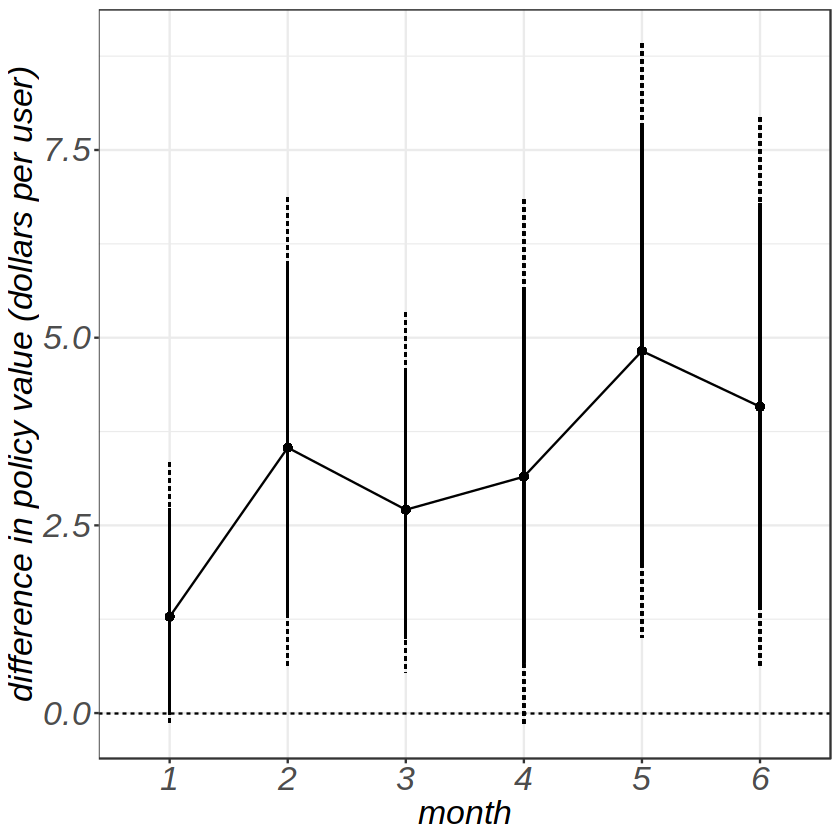

In [20]:
ggplot(ests_plot, aes(time,mean,group = 1)) + 
  geom_line() +
  geom_point() +
  geom_errorbar(aes(ymin=ci_95_lower, 
                    ymax=ci_95_upper), width=0, linetype = 'dashed') + 
  geom_errorbar(aes(ymin=ci_75_lower, 
                    ymax=ci_75_upper), width=0) + 
  theme_bw() + 
geom_hline(yintercept = 0, linetype = 'dashed') +
scale_x_discrete(limits = factor(c(1:6))) + 
scale_color_grey() +
xlab('month') + 
ylab('difference in policy value (dollars per user)') +
theme(axis.text = element_text(size = 20), axis.title = element_text(size = 20))   